# TODO:
- I mostly skimmed this file (in contrast to the auto-encoder, where I added lots of TODOs)
    - I should take another pass, but this file is in reasonably good shape already
- Mostly, I just want to move the dependencies/configuration up to the top, and clean-up the description a bit
- I noticed at least one image that I labeled wrong, so maybe review those
- Check the model architecture, thinking about overfitting, and best practices
    - consider just using VGG, ImageNet, or something pre-trained, instead of working from scratch
- Consider some callbacks for early stopping

# What is in this notebook?
This notebook contains a general image classification model built for scratch. It is easy to follow, and trains _relatively_ quickly (< 1 hour for a few hundred images, running locally on my modest laptop - much faster on GPU, colab, etc.). This was important, because as a learning tool, this notebook is here for reference and experimentation, and training cycles of days and weeks would also rapid enough iteration.

A few of the features explored in this notebook:
- Sequential models  (Tensorflow)
- data generator, including memory efficient data augmentation and resizing tricks (Tensorflow)
- flow from directory (creates data, and manages labels - though the structure is a bit counter-intuitive, lumping the label into another dimension of the tensor, rather than a dedicated property)
- Tuning of some hyperparameters (I've deleted most commented alternatives, but made the inputs explicit, even when those inputs match the default)
- Training and saving model & parameters
- Deployment (sort of - I'm still using eager execution)
- Assessment and Visualization tools to understand where the algorithm struggles and why  


# Problem Statement:
This is an imaging application, in which I needed to characterize welds as good/bad. I had previously 
- The details are proprietary, but it is a manufacturing application, so the features of interest are similar between images, the scale and orientation are fixed, lighting is theoretically fixed (though that assumption broke down a bit in practice), and position of the key feature is generally near the center (at least the full feature of interest is entirely visible in all my data). The objective was to determined pass/fail based on the state of the feature of interest. 
    - This was successful in 100% of test images, with extremely high percentages in most cases, so this made an excellent proof of *concept.
    - As a side note, I have another application that explored solutions through autoencoders for anomaly detection)


# Purpose:
1) Gain hands-on experience with Tensorflow - lots of theory bouncing around in my head, and I needed to start putting it in action to solidify those concepts. 
    - Although experimented with tuning a few hyperparameters, plotting loss over epochs, etc. Most of this was removed from the notebook, because it just felt like clutter upon review. However, I left a few plotting methods that could be used as examples or outright re-used in future projects.
    
2) Proof of concept (business case): In this case, I had both human labeled data and a solution created with traditional computer vision methods, which had already been shown to improve upon human performance. I wanted to evaluate whether a CNN could achieve a high enough level of performance to meeting the exacting standards of a highly regulated production environment, and determine whether it was a viable option for future applications. In particular, I wanted to answer the following questions:
- Can performance achieve the level of accuracy/precision required for this application?
- Can a single CNN be applied to multiple vision applications (possibly with hyperparameter tuning)?
    - This would greatly reduce development, and time to deploy (which is highly manual, because of the regulatory oversight)
- Can a CNN tackle more complex/subtle identifications, which traditional vision techniques struggled with. 
    - In particular, there were specific failure modes I was aware of, which could be detected by the existing methods, but also triggered false negatives, and required additional human expert analysis. 
- Could models be trained with relatively low amounts of data. ML often gets branded as requiring big data. While this is not wrong, I knew we could control some of the conditions in our production setting, leading to far less variability than most "big data" applications.
    - For reference, I have ~300 images, with mostly good images, and only a handful of each failure mode, but could aqcuire more if needed, for additional cost. Additional collection would not be a show-stopper, but would be a business cost, making this option less attactive.

3) Application 2 (just for fun): I put this together in my spare time, so I decided to take some videos on my phone, and check my performance on a more general, real-world data set. In practice, I took video of the objects of interest, and treated this as a presence detector. 
    - I'm achieving about 93% accuracy on a set of 150 positive / 150 negative examples, using early stopping. I'm pretty happy with that, considering the size of the data set. Longer training doesn't seem to improve much, and the test loss starts increasing. It's pretty noisy with such a small data set, but I'm happy with it for now.
    - Technically, a simple logistic model would have been more appropriate, rather than a multi-class classifier, but I liked that I could extend the model from application 1, and also liked the idea of potentially adding classes as needed.
    - Since these images represent more real-world variability, a transfer learning model would have probably worked better, but that was beyond the scope of this excercise (plans are in the making though!).

# What is not in this notebook?
Minimal effort has been put into evaluating performance on final data sets. A train/test split was observed, but not a full train/test/dev. I was lucky to have a key data set with such a controlled application, making Variance/overfitting was not a big concern. That said, I didn't add in any regularization or dropout layers.

# Next Steps
That's probably it for now. The business application is no longer applicable at this point. If I were to coninue, I might add: 
- logging/saving callbacks every few epochs.
- Integrate better visualizations, integrating the hooks for tensorboard

# Pre-processing
Preprocess_image(image) to crops, resizes, and performs a color correction (cv2 reads as RBG, rather than RGB, which needed to be corrected before displaying properly. I also played with splitting into train/test sets, and shuffling.

Tensorflow already has a lot of power in its approach with generators, so most of this proved redundant. I left a few of these methods just to read images into simple numpy arrays, without needing the full tensor structure. This makes data a bit easier to play around with and visualize.

My home dataset was generated by taking video, and then extracting every 10th frame (Free Video to JPG Converter : http://bit.ly/2susvOs). This was This definitely created some overfitting problems on my data (it was picking up background features in my home, because I had the objects of interest sitting in similar backgrounds)

# assumptions: 
 - input_dir contains sub-directories - the names of these directories are labels

ie:
  - All_Images
    - Label1
      - img1
      - img2
      - etc...
    - Label2
      - img1
      - img2
      - etc...

# Import the basics

In [1]:
from random import randint

import cv2

import os

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tools for pre-processing
- Show images
- Resize images

In [2]:
def show_img(images, predicted_labels, actual_labels = None, n_images = None, vmin=0, vmax=255):
    """
    images: np array of images
    labels: np array of [index, one-hot encoding of labels]
    """
    title_color_map = {True: "green", False: "red"}
    
    if actual_labels is None:
        title_color_map[True] = "black"
        actual_labels = predicted_labels
        
    if n_images is None:
        n_images = len(predicted_labels)
    
    n_cols = n_rows = math.ceil(math.sqrt(n_images))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(24, 24)) # (20/n_images, 20/n_images))
    if n_images==1:
        axs = [axs] # make sure axs is iterable (otherwise n_images==1 break it)
        
    i=1
    for ax, img, predicted_label, actual_label in zip(axs.flat, images, predicted_labels, actual_labels):
        ax.imshow(img, vmin= vmin, vmax = vmax)
        
        correct_prediction = (predicted_label == actual_label)
        ax.set_title(predicted_label, color=title_color_map[correct_prediction])

        ax.title.set_fontsize(20)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i+=1
        if(i>n_images):
            break

In [3]:
def crop_img(im, x1, x2, y1, y2):
    roi = im[y1:y2, x1:x2]
    return roi

In [4]:
def simple_square_crop(img):
    x1 = y1 = 0
    x2 = y2 = min(img.shape[1], img.shape[0])
    return crop_img(img, x1, x2, y1, y2)

In [5]:
def resize_and_maintain_aspect(img, target_width):
    """
    Resize image, maintaining aspect ratio.
    img: image to be re-scaled
    target_width: The target width in pixels of the resized image. 
    """
    
    height = img.shape[0]
    width = img.shape[1]

    ratio = width/target_width
    target_height = height//ratio
        
    dsize = (int(target_width), int(target_height))
    scaled_img = cv2.resize(img, dsize)
    
    return scaled_img

In [6]:
def shuffle_data(images, labels):
    shuffle = [x for x in range(len(labels))]
    np.random.shuffle(shuffle)
    
    images = np.array([images[i] for i in shuffle])
    labels = np.array([labels[i] for i in shuffle])
    
    return images, labels

In [7]:
def split_data(images, labels, split_index):
    return images[:split_index], labels[:split_index], images[split_index:], labels[split_index:]

In [8]:
def preprocess_image(img):
    # https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = simple_square_crop(img)
    img = resize_and_maintain_aspect(img, output_size)
    return img

In [9]:
def train_test_split(split_list, train_fraction, shuffle=True):
    if shuffle:
        shuffled_indeces = [x for x in range(len(split_list))]
        np.random.shuffle(shuffled_indeces)
        split_list = np.array([split_list[i] for i in shuffled_indeces])
    
    #split
    split_index = int(len(split_list)*train_fraction)
    return split_list[:split_index], split_list[split_index:]

test_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
train, test = train_test_split(test_list, .8)
print(train)

['f' 'l' 'e' 'd' 'p' 'k' 'm' 'a' 'n' 'b' 'o' 'j']


In [10]:
def mkdir_safe(path):
    """
    If directory already exists, safely exit without action.
    """
    if not os.path.exists(path):
        print("Creating parent directory for output images: \n\t%s" % (path))
        os.mkdir(path) 

In [11]:
def preprocess_and_save_images(output_dir, image_names, input_dir, class_name):
    output_dir = os.path.join(output_dir, class_name)
    input_dir = os.path.join(input_dir, class_name)
    mkdir_safe(output_dir)
        
    for image_index, image_name in enumerate(image_names):
        if (image_index % 50 == 0):
            print("Path: %s, \tLabel: %20s, \tIndex: %d" % (output_dir, class_name, image_index))
        input_path = os.path.join( input_dir, image_name)
        output_path = os.path.join(output_dir, image_name)
        
        image = cv2.imread(input_path) # cv2 seems to re-order channels to BGR
        preprocess_image(image)
        cv2.imwrite(output_path, image)

# Preprocess Data
    1) Resize images
    2) Load images from respective folders
    3) Shuffle images (carful to keep labels with images)
    4) Split into train/test

In [12]:
### Configure inputs ###

output_size = 256

# data_root = r"C:\Users\OptimizePrime\Desktop\MachineLearningArchive\Totoro"
data_root = r"C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro"

raw_data_dir = os.path.join(data_root, r"Totoro_Extracted")
# output_parent_dir = raw_data_dir + "_%dx%d" % (output_size, output_size)
train_parent_dir = os.path.join(data_root, "Train") 
test_parent_dir = os.path.join(data_root, "Test")


In [13]:
############ preprocess images ############
# Crop, Resize, re-order channels, shuffle, split into train/test and save back to train_parent_dir an test_parent_dir

# Extract label_names
class_names = [class_name for class_name in os.listdir(raw_data_dir) 
               if os.path.isdir(os.path.join(raw_data_dir,class_name))]
print("Class names found x%d:" % (len(class_names)), class_names )
assert(len(class_names) == 2)
mkdir_safe(train_parent_dir)
mkdir_safe(test_parent_dir)

for class_index, class_name in enumerate(class_names):
    # class_lookup[class_index] = class
    class_dir = os.path.join(raw_data_dir, class_name)
    image_names = os.listdir(class_dir)
    train_image_names, test_image_names = train_test_split(image_names, train_fraction=0.8)
    
    preprocess_and_save_images(train_parent_dir, train_image_names, raw_data_dir, class_name)
    preprocess_and_save_images(test_parent_dir, test_image_names, raw_data_dir, class_name)
    

Class names found x2: ['Background', 'Totoro']
Path: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\Train\Background, 	Label:           Background, 	Index: 0
Path: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\Train\Background, 	Label:           Background, 	Index: 50
Path: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\Test\Background, 	Label:           Background, 	Index: 0
Path: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\Train\Totoro, 	Label:               Totoro, 	Index: 0
Path: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\Train\Totoro, 	Label:               Totoro, 	Index: 50
Path: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\Test\Totoro, 	Label:               Totoro, 	Index: 0


# Data Pipeline Leveraging Keras & Tensorflow

In [14]:
# training data (explicitly put a bunch of defaults in - redundant and messy, but helpful at the moment)
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range= None, # [.1,1],
    shear_range=0.0,
    zoom_range=[.9,1.0],
    channel_shift_range=100,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=None,
    dtype=None,
)

batch_size = 32
target_size  = 256 # scale this up eventually, but let's develop with it small
save_dir = None # os.path.join(data_root,"augmented")
# Directories: input_parent_dir, output_parent_dir

train_data_gen = train_image_generator.flow_from_directory(
    directory = train_parent_dir,
    target_size=(target_size, target_size),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=save_dir,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 250 images belonging to 2 classes.


In [15]:
# test data (explicitly put a bunch of defaults in - redundant and messy, but helpful at the moment)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=[1.0,1.0],
    channel_shift_range=0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=None,
    dtype=None,
)

test_data_gen = test_image_generator.flow_from_directory(
    directory = test_parent_dir,
    target_size=(target_size, target_size),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None, # os.path.join(data_root,"augmented"),
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)
print(type(test_data_gen))
print(type(test_data_gen))
print(test_data_gen.on_epoch_end())

Found 212 images belonging to 2 classes.
<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
None


# Define Model

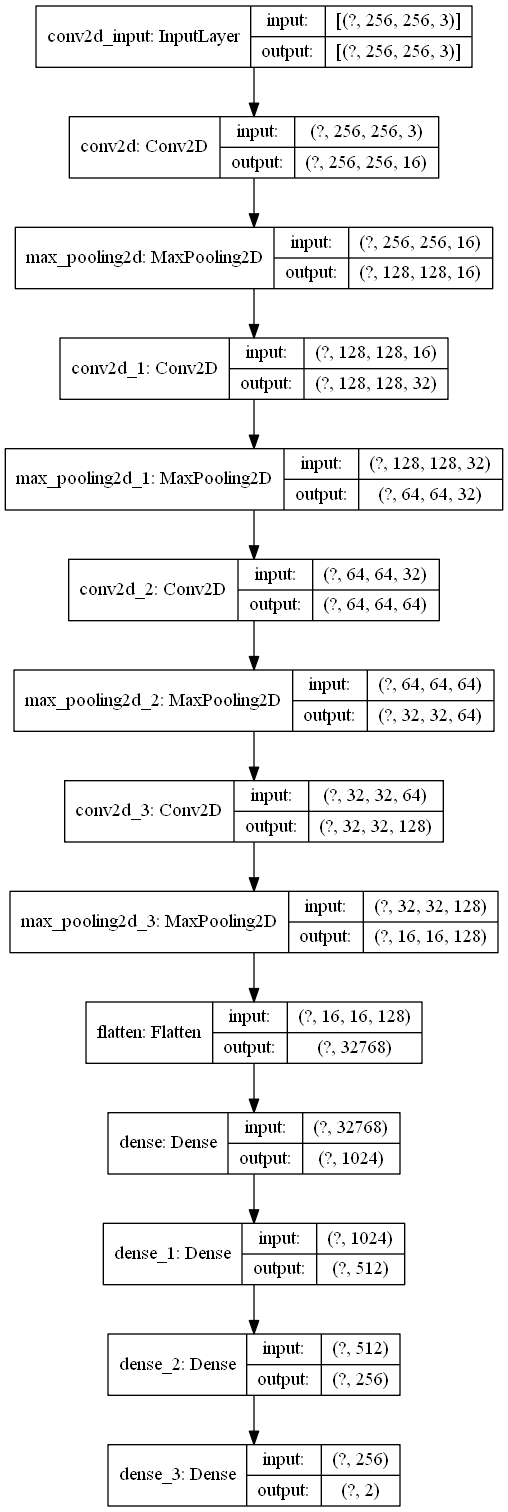

In [16]:
conv_model = tf.keras.models.Sequential([
    
    layers.Conv2D(16, (3, 3), padding='same', activation='relu',
                 input_shape=(target_size, target_size, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(1024, activation='relu'), # experimental layer (previously: converging to loss = .22ish, acc = .95ish. learning raate = 0.0000005)
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
    
])

keras.utils.plot_model(conv_model, 'model_image_classificaion_shapes.png',
                       show_shapes=True)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
conv_model.compile(optimizer= opt, # 'adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

# Train & Save

In [18]:
sample = train_data_gen.next()
print(len(sample)) # 2 (image, class_label)
image = sample[0]
label = sample[1]

print(image.shape) # Tensor of shape: (batch, height, width, channel)
print(label.shape) # Tensor of shape: (batch, one-hot-encoding)

print(label[0])

2
(32, 256, 256, 3)
(32, 2)
[1. 0.]


In [19]:
# train_data_gen = full_data_gen 
train_length = 7 # I made that up
test_length = 2 # made that one up too
epochs = 30 # At least 30, but probably check what 50+ is like
training_hist = conv_model.fit(train_data_gen,
                              epochs=epochs,
                              steps_per_epoch= train_length, # len(train_images) // batch_size),
                              validation_data=test_data_gen,
                              validation_steps= test_length) # len(test_images) // batch_size)

Epoch 1/30
7/7 [==============================] - 44s 6s/step - loss: 0.7007 - accuracy: 0.4541 - val_loss: 0.6714 - val_accuracy: 0.5938
Epoch 2/30
7/7 [==============================] - 41s 6s/step - loss: 0.6866 - accuracy: 0.5092 - val_loss: 0.6774 - val_accuracy: 0.5781
Epoch 3/30
7/7 [==============================] - 42s 6s/step - loss: 0.6856 - accuracy: 0.5321 - val_loss: 0.6723 - val_accuracy: 0.5938
Epoch 4/30
7/7 [==============================] - 44s 6s/step - loss: 0.6760 - accuracy: 0.6743 - val_loss: 0.6673 - val_accuracy: 0.6250
Epoch 5/30
7/7 [==============================] - 35s 5s/step - loss: 0.6658 - accuracy: 0.6376 - val_loss: 0.6648 - val_accuracy: 0.5938
Epoch 6/30
7/7 [==============================] - 38s 5s/step - loss: 0.6580 - accuracy: 0.6830 - val_loss: 0.6431 - val_accuracy: 0.6562
Epoch 7/30
7/7 [==============================] - 42s 6s/step - loss: 0.6549 - accuracy: 0.7477 - val_loss: 0.6425 - val_accuracy: 0.8594
Epoch 8/30
7/7 [==================

In [20]:
model_name = os.path.join(data_root, "trained_model")
conv_model.save(model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\OptimizePrime\Desktop\TrevorStuff\DataSets_TooBigForProjectRepos\WeldImages\Totoro\trained_model\assets


In [21]:
loaded_model = tf.keras.models.load_model(model_name)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

# Analyze

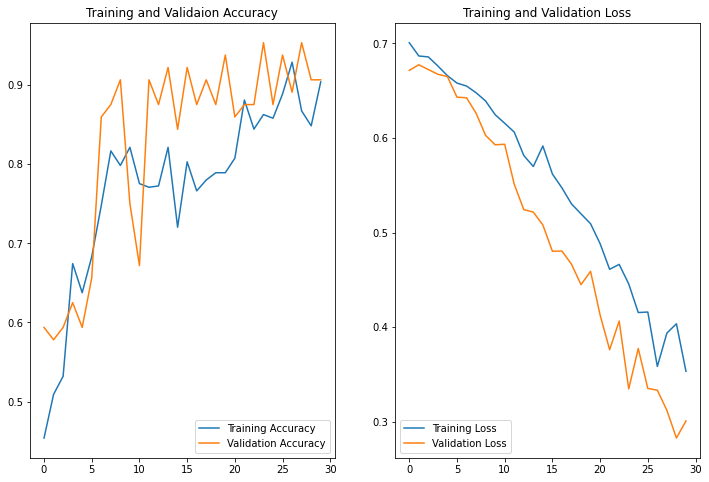

In [22]:
# These results are junk on the validation data (even the instructor didn't have rising validation loss - what's with that?)
# We'll see if adding dropouts in a later step fixes, but I'm unclear why these results are so bad
acc = training_hist.history['accuracy']
val_acc = training_hist.history['val_accuracy']
loss = training_hist.history['loss']
val_loss = training_hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validaion Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# training_hist.__doc__

# from keras.callbacks import CSVLogger

# csv_logger = CSVLogger("model_history_log.csv", append=True)
# model.fit_generator(...,callbacks=[csv_logger])

In [24]:
# with open('/trainHistoryDict', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

# Deploy

In [25]:
lookup = {1: "Totoro", 0: "Not Totoro"}
# lookup = {0 : "UnWelded", 1:"Welded"}
def perform_test(model, img, actual_one_hot, verbose=False):
    """
    model: The tf.model used for prediction
    img: The image (for display purposes)
    label:
        If this is an int, then label is assumed to be a class id
        If this is an array, then label is assumed to be a one-hot encoding
    """
        
    test_img = np.expand_dims(img, axis=0)
    predicted_one_hot = model.predict(test_img)
    predicted = lookup[np.argmax(predicted_one_hot)]
    actual = lookup[np.argmax(actual_one_hot)]
    
    if verbose:
        plt.imshow(img)
        print("\n------------------------------------------")
        print('Actual label: \t\t', actual)
        print('Predicted label:\t', predicted)
        print("Was predicted answer correct?\t %r" % (actual == predicted))
        
        probabilities = model.predict_proba(test_img)
        for key, val in lookup.items():
            print(val, ":\t", probabilities[0][key])
    
    return (actual == predicted, 
             model.predict_proba(test_img)[0][np.argmax(predicted_one_hot)])

Batch Length:  32
Finding lowest confidence prediction...
Failing classifications will be printed...
Instructions for updating:
Please use `model.predict()` instead.

------------------------------------------
Actual label: 		 Not Totoro
Predicted label:	 Totoro
Was predicted answer correct?	 False
Totoro :	 0.68261313
Not Totoro :	 0.31738687
Index of failure:  0

------------------------------------------
Actual label: 		 Totoro
Predicted label:	 Not Totoro
Was predicted answer correct?	 False
Totoro :	 0.22567365
Not Totoro :	 0.7743263
Index of failure:  16

------------------------------------------
Actual label: 		 Not Totoro
Predicted label:	 Totoro
Was predicted answer correct?	 False
Totoro :	 0.51877224
Not Totoro :	 0.48122782
Index of failure:  22


Lowest confidence:  0.5008281


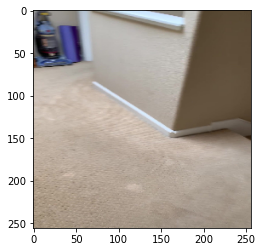

In [26]:
import random
batch = test_data_gen.next()
batch_length = batch[0].shape[0]
print("Batch Length: ", batch_length)
print("Finding lowest confidence prediction...")
print("Failing classifications will be printed...")
lowest_confidence = 1
for index in range(len(batch[0])):
    img = batch[0][index]
    one_hot = batch[1][index]
    result, prob = perform_test(conv_model, img, one_hot, verbose=False)
    lowest_confidence = min(prob, lowest_confidence)

    if(not result):
        perform_test(conv_model, img, one_hot, verbose=True)
        print("Index of failure: ", index)
    
print("\n\nLowest confidence: ", lowest_confidence)


------------------------------------------
Actual label: 		 Not Totoro
Predicted label:	 Not Totoro
Was predicted answer correct?	 True
Totoro :	 0.37462
Not Totoro :	 0.62538004
(True, 0.62538004)


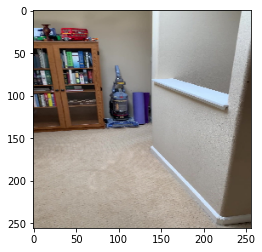

In [27]:
rand_index = random.randrange(0, batch_length)
img = batch[0][rand_index]
one_hot = batch[1][rand_index]

correct = perform_test(conv_model, img, one_hot, verbose=True)
print(correct)

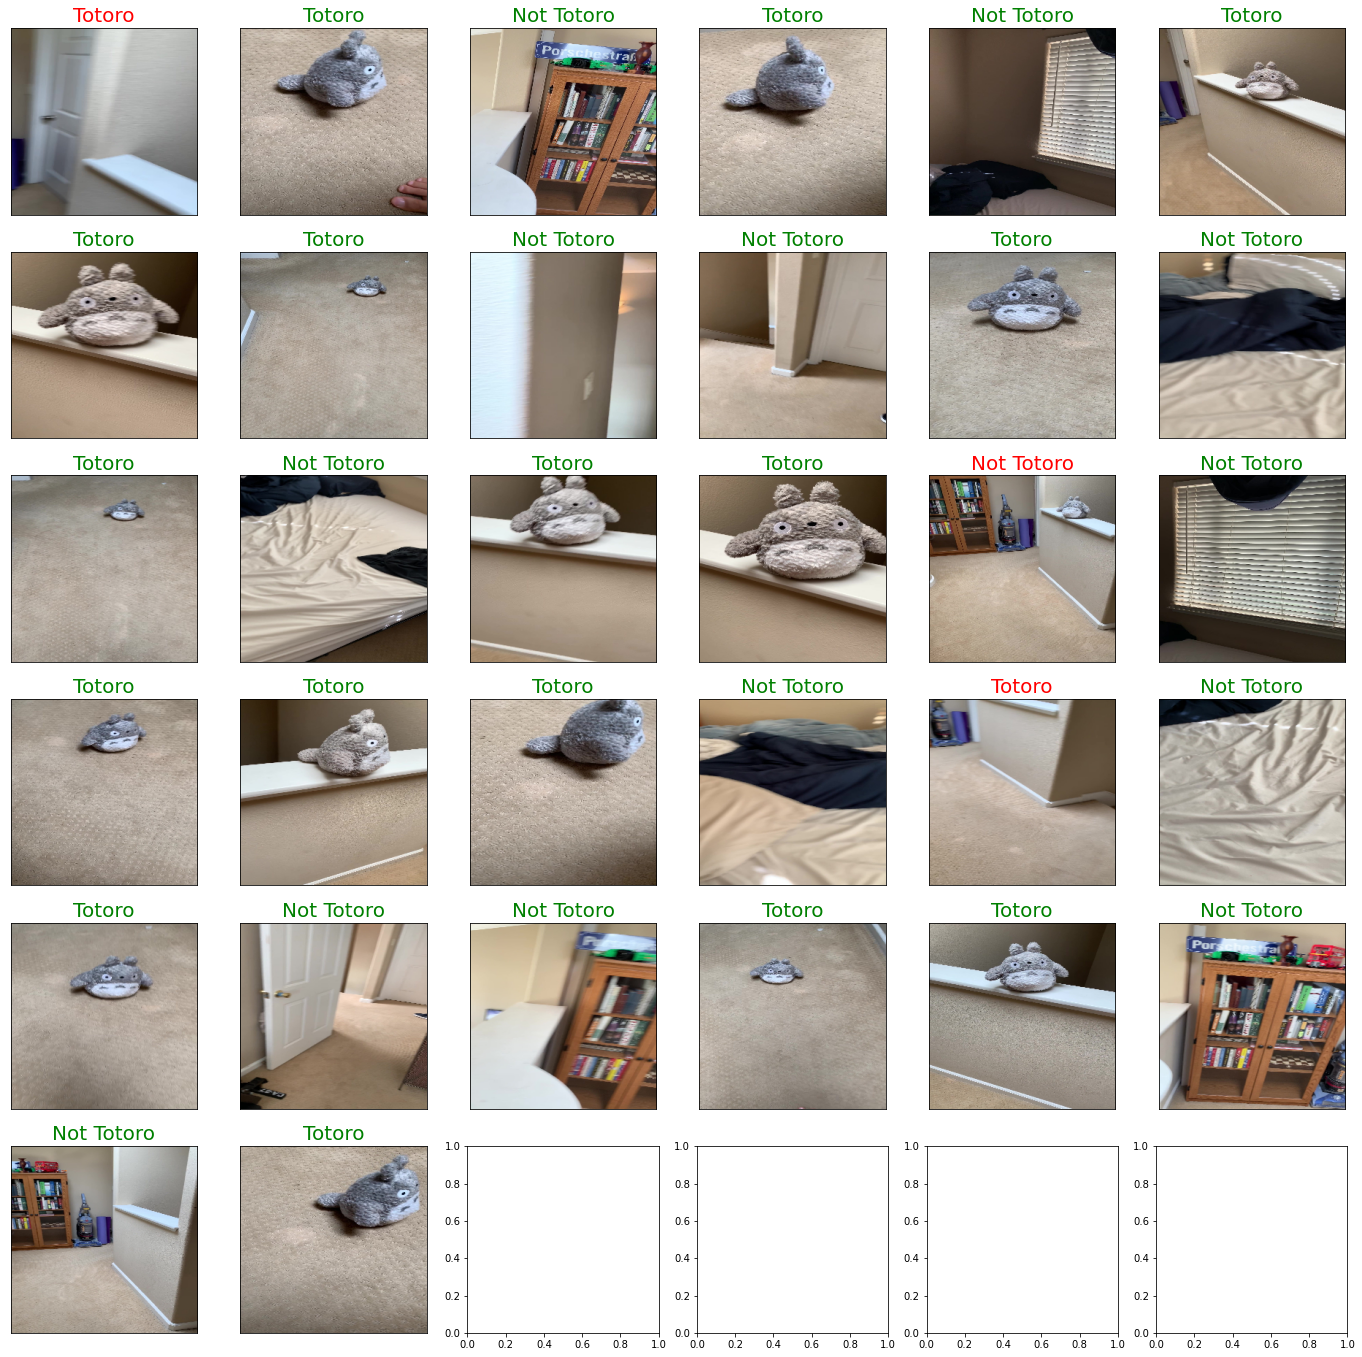

In [28]:
images = batch[0]
actual_one_hots = batch[1]
actual_labels = [ lookup[np.argmax(one_hot)] for one_hot in actual_one_hots ]

def predict_label(img):
    img = np.expand_dims(img, axis=0)
    prediction = conv_model.predict(img)
    label = lookup[np.argmax(prediction)]
    return label

predicted_labels = [ predict_label(image) for image in images ]
show_img(images, predicted_labels, actual_labels)

In [29]:
batch = batch + batch
len(batch)

4